In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

In [ ]:
df = pd.read_csv('listings.csv')
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5396,Your perfect Paris studio on Île Saint-Louis,7903,Borzou,NaN,Hôtel-de-Ville,48.852470,2.358350,Entire home/apt,88.0,3,425,2024-11-23,2.26,1,77,51,7510402838018
1,7964,Sunny apartment with balcony,22155,Anaïs,NaN,Opéra,48.874170,2.342450,Entire home/apt,NaN,7,5,2015-09-14,0.03,1,0,0,7510903576564
2,9952,Paris petit coin douillet,33534,Elisabeth,NaN,Popincourt,48.862380,2.369570,Entire home/apt,150.0,4,52,2024-09-24,0.36,1,250,3,7511101582862
3,11487,"Heart of Paris, brand new aparment.",42666,Brigitte,NaN,Popincourt,48.863510,2.371100,Entire home/apt,80.0,30,13,2024-09-27,0.09,2,246,5,"Available with a mobility lease only (""bail mo..."
4,12452,Voltaire Charm,48733,Irene,NaN,Popincourt,48.859740,2.379320,Entire home/apt,201.0,1,62,2024-10-11,0.77,1,34,4,7511102600669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91026,1304562779094087796,Studio ensoleillé sur Canal,38574929,Anna,NaN,Buttes-Chaumont,48.888360,2.382689,Entire home/apt,100.0,30,0,NaN,NaN,1,85,0,"Available with a mobility lease only (""bail mo..."
91027,1304667478167694444,Studio bohémien,595527331,Ahmed,NaN,Ménilmontant,48.864770,2.391108,Entire home/apt,80.0,1,0,NaN,NaN,1,180,0,7512014848156
91028,1305050902233494632,Cozy Apartment - Marais - Pelee,156775524,Merveil,NaN,Popincourt,48.859996,2.369208,Entire home/apt,818.0,1,0,NaN,NaN,107,264,0,7511114844445
91029,1305061192394005038,Cozy Apartment - Tour Eiffel - Finlay,156775524,Merveil,NaN,Vaugirard,48.852970,2.288317,Entire home/apt,840.0,1,0,NaN,NaN,107,316,0,7511514844533


In [3]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [4]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

In [5]:
print(df.isnull().sum()) #missing values per column

id                                    0
name                                  0
host_id                               0
host_name                             9
neighbourhood_group               91031
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30938
minimum_nights                        0
number_of_reviews                     0
last_review                       23855
reviews_per_month                 23855
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18786
dtype: int64


In [6]:
perc = round(df.isnull().sum() / len(df), 2) * 100 #percentage of missing values
missing_columns = perc[perc > 0] # filtering and displaying columns with missing values
print(missing_columns) 


neighbourhood_group    100.0
price                   34.0
last_review             26.0
reviews_per_month       26.0
license                 21.0
dtype: float64


In [7]:
df = df.drop(columns=['neighbourhood_group']) #dropping columns where missing values > 50%

In [8]:
#imputing low missing value columns
df['price'] = df['price'].fillna(df['price'].median()) 
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median())


In [9]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce') #converting date columns to datetime

In [10]:
review_columns = ['last_review', 'reviews_per_month'] #imputing review-related columns
for col in review_columns:
    df[col] = df[col].fillna(df[col].median())
print(df.isnull().sum()) #verifying missing values after imputation

id                                    0
name                                  0
host_id                               0
host_name                             9
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18786
dtype: int64


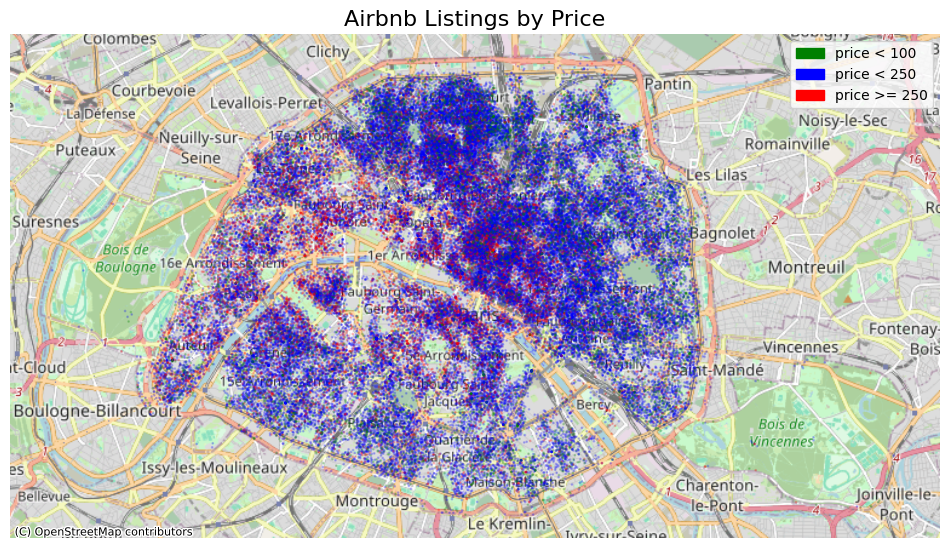

In [11]:
import matplotlib.patches as patches
import matplotlib.patches as mpatches

#converting latitude and longitude into Point geometries
df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

#assigning colors based on price
gdf['color'] = gdf['price'].apply(lambda p: 'green' if p < 100 else 'blue' if p < 250 else 'red')


#plotting
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=1, alpha=0.2)

#adding basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Airbnb Listings by Price", fontsize=16)
ax.set_axis_off()
green_patch = mpatches.Patch(color='green', label='price < 100')
blue_patch = mpatches.Patch(color='blue', label='price < 250')
red_patch = mpatches.Patch(color='red', label='price >= 250')
plt.legend(handles=[green_patch, blue_patch, red_patch])
plt.show()


# Univariate Analysis

In [12]:
df['price'].describe()

count    91031.000000
mean       217.723852
std        485.253426
min          7.000000
25%        121.000000
50%        150.000000
75%        187.000000
max      30400.000000
Name: price, dtype: float64

## Detecting outliers in 'price' column

In [13]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"Number of outliers in 'price': {len(outliers)}")

print("\nOutlier prices:")
print(outliers['price'].describe())

df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


Number of outliers in 'price': 11991

Outlier prices:
count    11991.000000
mean       710.743724
std       1222.182811
min          7.000000
25%        337.000000
50%        419.000000
75%        616.000000
max      30400.000000
Name: price, dtype: float64


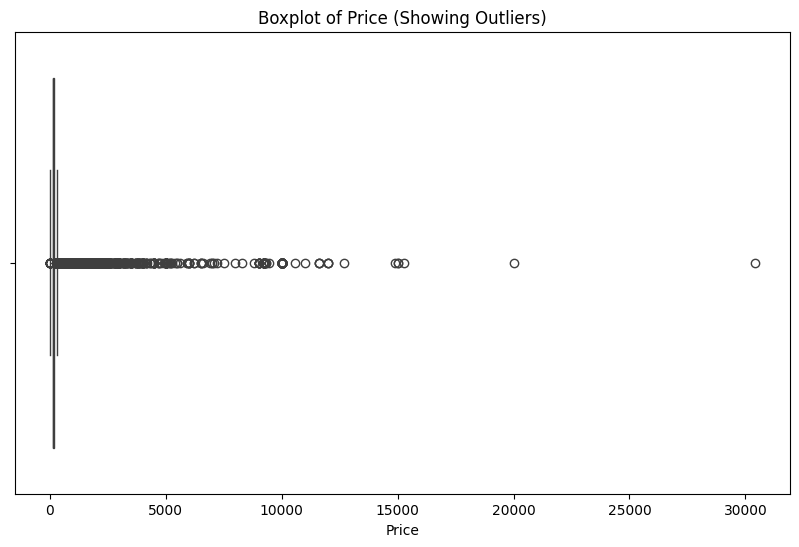

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price (Showing Outliers)')
plt.xlabel('Price')
plt.show()

## Price distribution after handling outliers

**I used Sturges' Rule**: $$ \text{Number of bins} = 1 + \log_2(n)$$, where $ n $ is the number of data points.

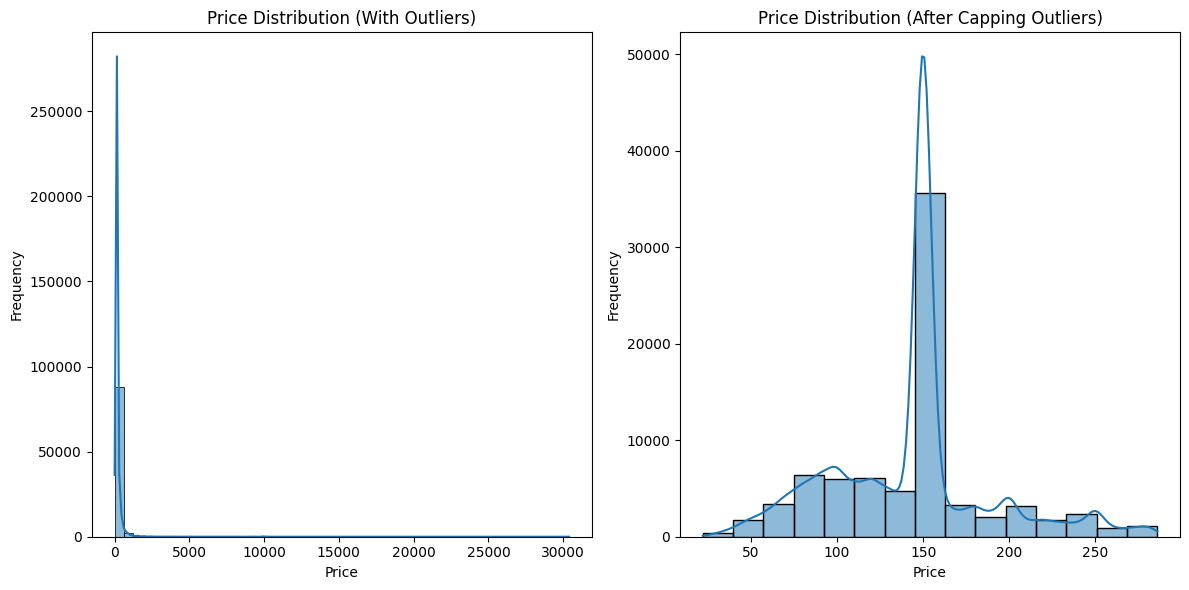

In [15]:
n = len(df)
n_cleaned = len(df_cleaned)
bins_with_outliers = int(1 + np.log2(n))
bins_without_outliers = int(1 + np.log2(n_cleaned))

#before handling outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution (With Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')

#after handling outliers (using capped data)
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['price'], bins=15, kde=True)
plt.title('Price Distribution (After Capping Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

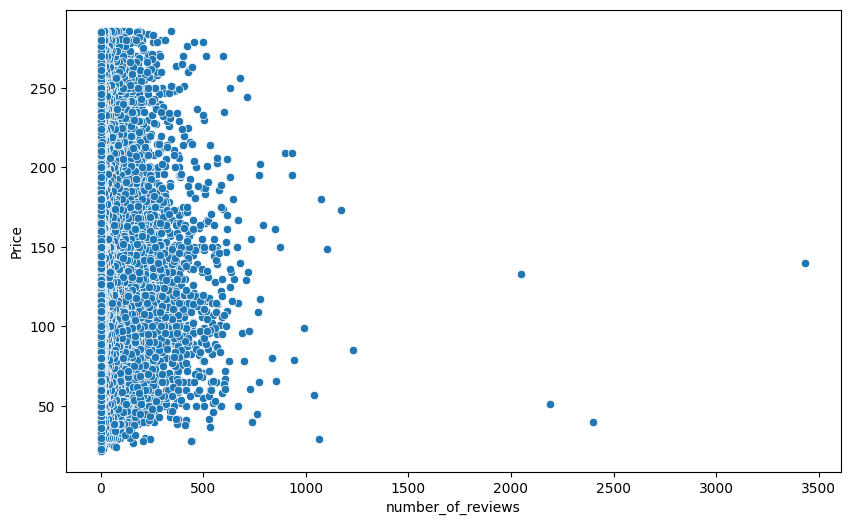

In [16]:
# Price vs. Review Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='price', data=df_cleaned)
plt.ylabel('Price')
plt.show()

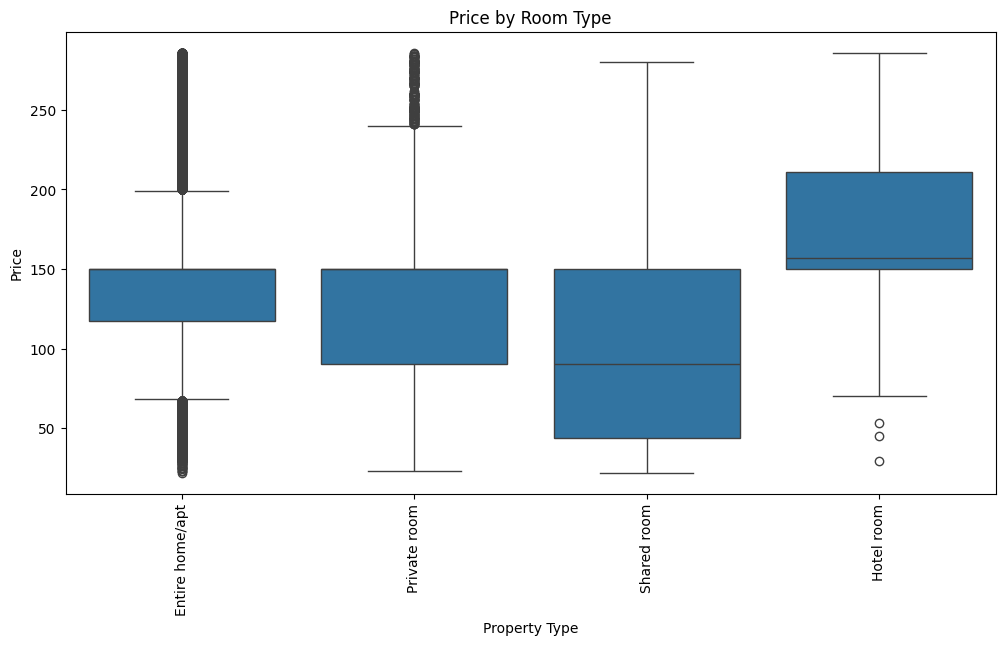

In [17]:
# Price by Property Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df_cleaned)
plt.title('Price by Room Type')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

# Multivariate analysis

In [18]:
df.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
license                                   object
geometry                                  object
dtype: object

## Pairplot

Text(0.5, 0.98, 'Pair Plot of Numerical Variables')

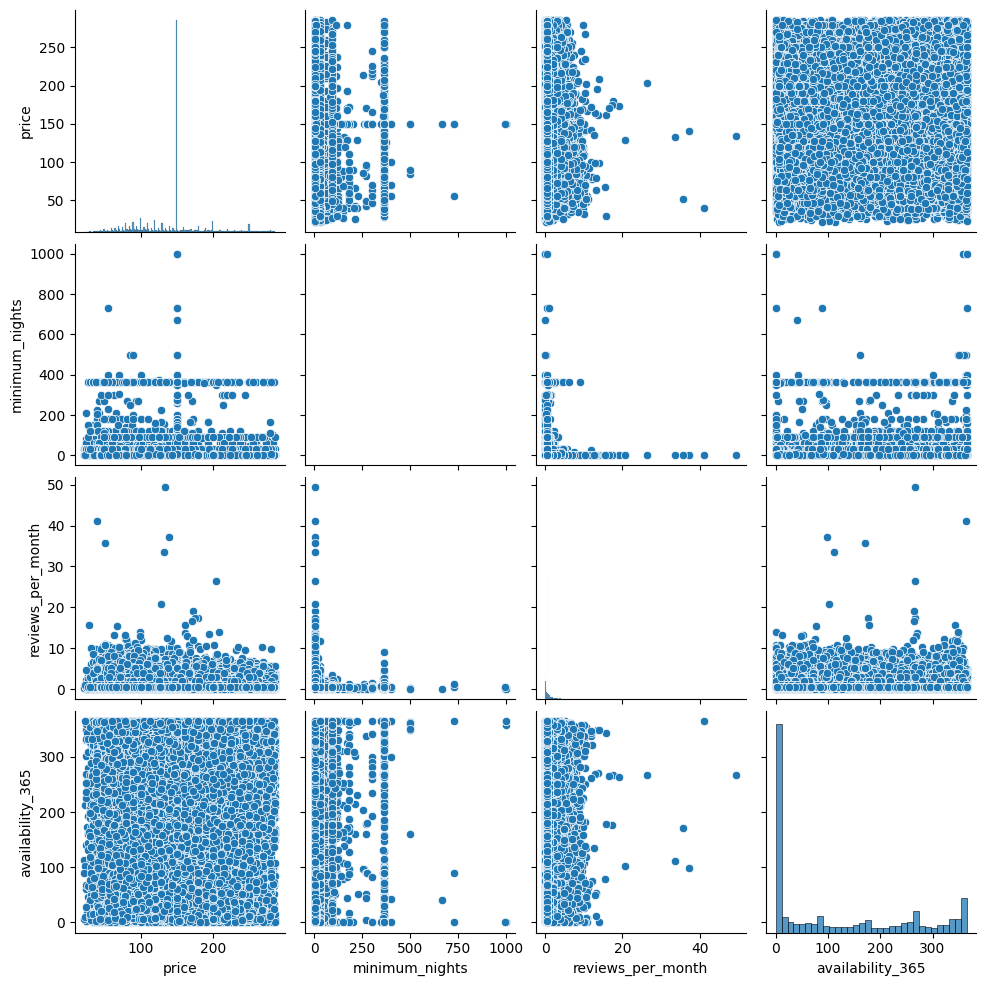

<Figure size 800x600 with 0 Axes>

In [19]:
numerical_columns = ['price', 'minimum_nights', 'reviews_per_month', 'availability_365']
sns.pairplot(df_cleaned[numerical_columns])
plt.figure(figsize=(8,6))
plt.suptitle('Pair Plot of Numerical Variables')

### Conclusion: obviously, we can see that there is no linear regression

## Correlation Heatmap

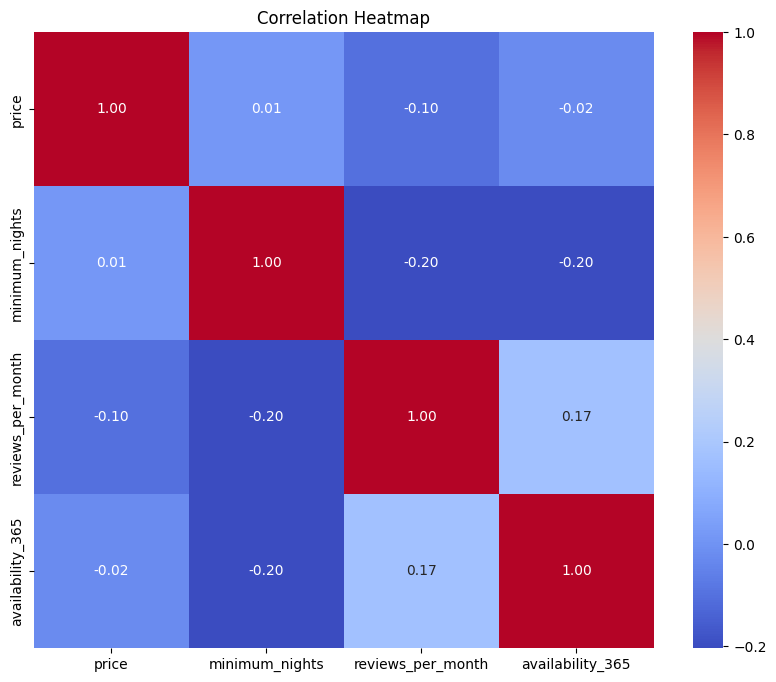

In [20]:
corr_matrix = df_cleaned[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Conclusion: there is no strong correlation between any numberical variables

## Faceted scatter plot: Price vs. Number of Reviews, faceted by Room Type

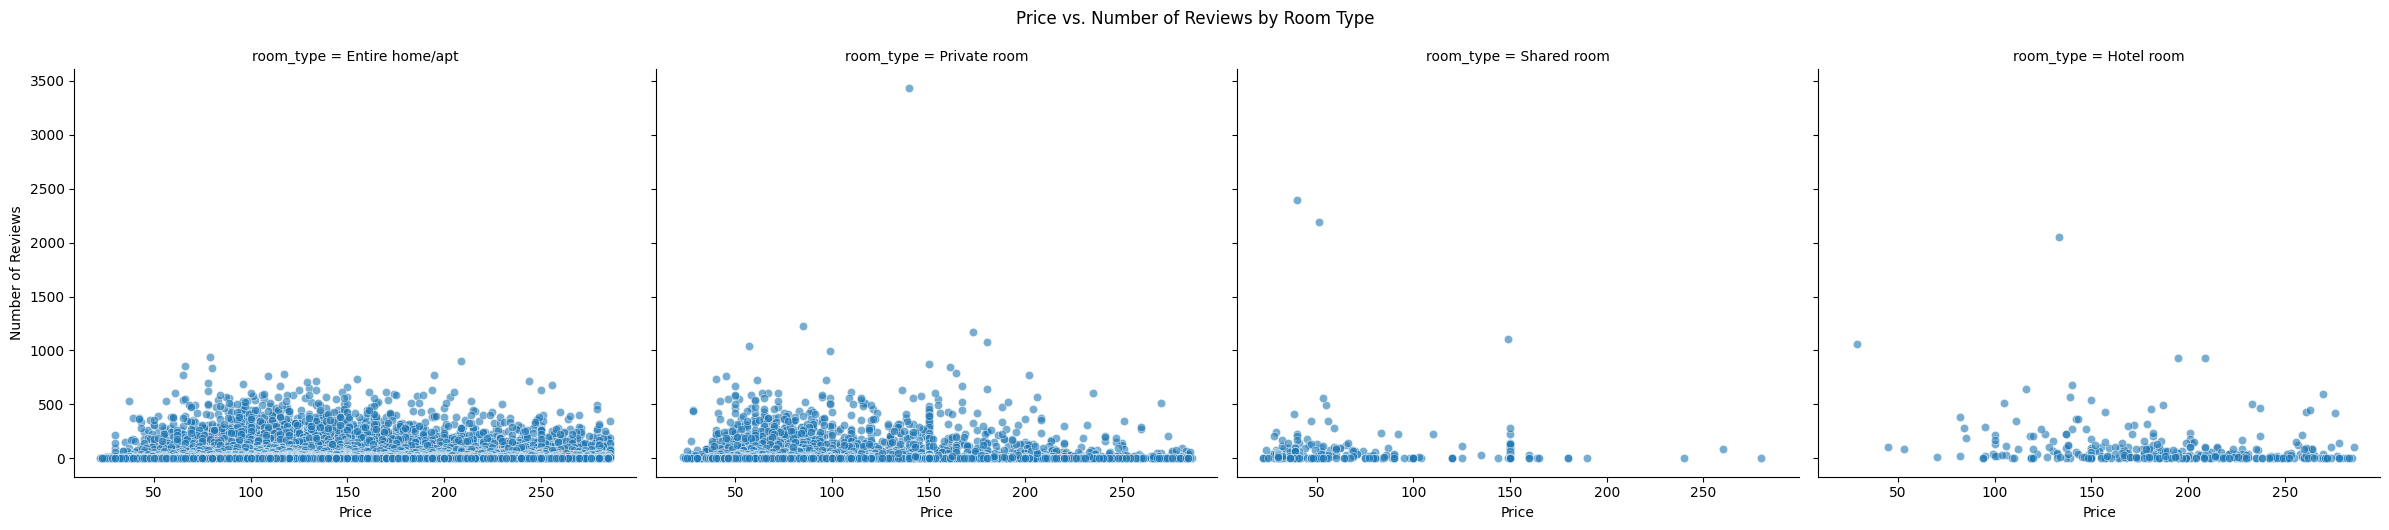

In [21]:
g = sns.FacetGrid(df_cleaned, col='room_type', height=5, aspect=1.2)
g.map(sns.scatterplot, 'price', 'number_of_reviews', alpha=0.6)
g.set_axis_labels('Price', 'Number of Reviews')
g.fig.suptitle('Price vs. Number of Reviews by Room Type', y=1.05)
plt.show()